# Implementação de Filtros Digitais

Neste tutorial vamos ver a implementação de um filtro digital dado por:
<br>
$$
y\left[n\right] + a_1~y\left[n-1\right] + a_2~y\left[n-2\right] + \ldots + a_N~y\left[n-N\right] = b_0~x\left[n\right] + b_1~x\left[n-1\right] + b_2~x\left[n-2\right] + \ldots + b_N~x\left[n-N\right]
$$
<br>
Sabemos que a função de transferência deste filtro é dada por:

$$
H\left(z\right) = \frac{Y\left(z\right)}{X\left(z\right)} = \frac{b_0 z^N + b_1 z^{N-1} + \ldots + b_{N-1}z + b_N}{z^N + a_1 z^{N-1} + \ldots + a_{N-1} z + a_N}
$$

<br>
<br>
<br>
Todas as implementações estão considerando que o número de coeficientes $a_i$ e $b_i$ são iguais, e que o coeficiente $a_0 = 1$ (ou seja, o filtro está normalizado).

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import time

In [2]:
sinal = sp.io.loadmat('noisy_ecg_data_2.mat')['noisy_ecg2'].ravel()

In [3]:
b, a = sp.signal.butter(2, 0.2, 'lowpass')

## Implementação via equação de diferenças

A primeira implementação, mais ingênua, consiste apenas em isolar $y\left[n\right]$ na equação de diferenças.

$$
y\left[n\right] = - a_1~y\left[n-1\right] - a_2~y\left[n-2\right] - \ldots - a_N~y\left[n-N\right] + b_0~x\left[n\right] + b_1~x\left[n-1\right] + b_2~x\left[n-2\right] + \ldots + b_N~x\left[n-N\right]
$$

Ou, de forma mais compacta:

$$
y\left[n\right] = \sum_{i = 1}^N -a_i~y\left[n-i\right] + \sum_{i=0}^N b_i~x\left[n-i\right]
$$


In [4]:
def diffEquation(B,A,x):
    y = np.zeros(x.size)
    
    for n in range(x.size):
        tempSum = 0
        
        for i in range(1,A.size):
            if n >= i:
                tempSum += - A[i] * y[n-i]
        
        for i in range(B.size):
            if n >= i:
                tempSum += B[i] * x[n-i]
        y[n] = tempSum

    return y    

## Forma Direta 1

Na implementação na forma direta 1 começamos separanda a função de transferência em duas partes:

$$
\begin{align}
H\left(z\right) &= \frac{b_0 z^N + b_1 z^{N-1} + \ldots + b_{N-1}z + b_N}{z^N + a_1 z^{N-1} + \ldots + a_{N-1} z + a_N} \\
	                &= \dfrac{\vphantom{\dfrac{\tilde{E}}{\tilde{E}}} b_0 + b_1 \dfrac{1}{z} + \ldots + b_{N-1}\dfrac{1}{z^{N-1}} + b_N \dfrac{1}{z^N}} { \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} 1 + a_1 \dfrac{1}{z} + \ldots + a_{N-1} \dfrac{1}{z^{N-1}} + a_N \dfrac{1}{z^N} } 									
\end{align}
$$

E então:

$$
\begin{align}
	&H\left(z\right) = \underbrace{\left( \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} b_0 + b_1 \dfrac{1}{z} + \ldots + b_{N-1}\dfrac{1}{z^{N-1}} + b_N \dfrac{1}{z^N} \right)}_{H_1\left(z\right)} \cdot \underbrace{ \left( \dfrac{1} { \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} 1 + a_1 \dfrac{1}{z} + \ldots + a_{N-1} \dfrac{1}{z^{N-1}} + a_N \dfrac{1}{z^N} } \right)}_{H_2\left(z\right)} 
\end{align}
$$

Podemos então implementar a função de transferência como:

$$
\begin{align}
	W\left(z\right) &= H_1\left(z\right) \cdot X\left(z\right) \\
    Y\left(z\right) &= H_2\left(z\right) \cdot W\left(z\right) 
\end{align}
$$

$$
\begin{align}
	W\left(z\right) &= \left( \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} b_0 + b_1 \dfrac{1}{z} + \ldots + b_{N-1}\dfrac{1}{z^{N-1}} + b_N \dfrac{1}{z^N} \right) \cdot X\left(z\right) \\
	                &= \left( \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} 1 + a_1 \dfrac{1}{z} + \ldots + a_{N-1} \dfrac{1}{z^{N-1}} + a_N \dfrac{1}{z^N} \right) \cdot Y \left(z\right)
\end{align}
$$

E finalmente:
$$
\begin{align}
	W\left(z\right) &= \left( \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} b_0 + b_1 \dfrac{1}{z} + \ldots + b_{N-1}\dfrac{1}{z^{N-1}} + b_N \dfrac{1}{z^N} \right) \cdot X\left(z\right)  \\
	Y\left(z\right) &= W\left(z\right) - \left( \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} a_1 \dfrac{1}{z} + \ldots + a_{N-1} \dfrac{1}{z^{N-1}} + a_N \dfrac{1}{z^N} \right) \cdot Y \left(z\right) 
\end{align}
$$

<center><img src="./figs/forma_direta_1_filter.png" width="500"></center>

In [5]:
def FD1(B,A,x):
    y = np.zeros(x.size)

    zx = np.zeros(B.size)
    zy = np.zeros(A.size)

    for n in range(x.size):
        wn = B[0] * x[n] + zx[0]
        y[n] = wn + zy[0]

        #Calculo a linha de atraso da entrada (zx)
        for i in range(1,B.size):
            zx[i-1] = B[i]*x[n] + zx[i]

        #Calculo a linha de atraso da saída (zy)
        for i in range(1,A.size):
            zy[i-1] = -A[i] * y[n] + zy[i]

    return y

Sobre a implementação na <b>Forma Direta 1</b>:

<ul>
    <li>Essa implementação pode ser pensada como um filtro composto apenas por zeros seguido de um filtro composto apenas por pólos.</li>
    <li>Essa implementação tem o dobro de atrasos do que o necessário (2N atrasos).</li>
    <li>Em implementação em <b>ponto fixo</b> em complemento de 2, não há a possibilidade de overflow interno se a saída $y\left[n\right]$ estiver dentro do intervalo da palavra.</li>
    <li>Essa implementação tem problema de quantização dos coeficientes.</li>	
</ul>

## Forma Direta 2

A implementação na Forma Direta 2 consiste em inverter a ordem de aplicação dos filtros:

$$
\begin{align}
	H\left(z\right) = \underbrace{ \left( \dfrac{1} { \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} 1 + a_1 \dfrac{1}{z} + \ldots + a_{N-1} \dfrac{1}{z^{N-1}} + a_N \dfrac{1}{z^N} } \right)}_{H_2\left(z\right)} \cdot \underbrace{\left( \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} b_0 + b_1 \dfrac{1}{z} + \ldots + b_{N-1}\dfrac{1}{z^{N-1}} + b_N \dfrac{1}{z^N} \right)}_{H_1\left(z\right)}									
\end{align}
$$

Podemos então implementar a função de transferência da seguinte forma: 

$$
\begin{align}
	V\left(z\right) &= H_2\left(z\right) \cdot X\left(z\right) \\
  Y\left(z\right) &= H_1\left(z\right) \cdot V\left(z\right) 
\end{align}
$$

$$
\begin{align}
	V\left(z\right) &= \left( \dfrac{1} { \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} 1 + a_1 \dfrac{1}{z} + \ldots + a_{N-1} \dfrac{1}{z^{N-1}} + a_N \dfrac{1}{z^N} } \right) \cdot X\left(z\right)  \\
	                &= \left( \dfrac{1} {\vphantom{\dfrac{\tilde{E}}{\tilde{E}}} b_0 + b_1 \dfrac{1}{z} + \ldots + b_{N-1}\dfrac{1}{z^{N-1}} + b_N \dfrac{1}{z^N} } \right) \cdot Y \left(z\right) 
\end{align}
$$

E então:

$$
\begin{align}
	V\left(z\right) &= X\left(z\right) - \left( \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} a_1 \dfrac{1}{z} + \ldots + a_{N-1} \dfrac{1}{z^{N-1}} + a_N \dfrac{1}{z^N} \right) \cdot V \left(z\right) \nonumber \\
	Y\left(z\right) &= \left( \vphantom{\dfrac{\tilde{E}}{\tilde{E}}} b_0 + b_1 \dfrac{1}{z} + \ldots + b_{N-1}\dfrac{1}{z^{N-1}} + b_N \dfrac{1}{z^N} \right) \cdot V\left(z\right) \nonumber
\end{align}
$$

<center><img src="./figs/forma_direta_2_filter.png" width="500"></center>

Ou:

<center><img src="./figs/forma_direta_2_merged_delays_filter.png" width="500"></center>


In [6]:
def FD2(B,A,x):
    y = np.zeros(x.size)

    z = np.zeros(B.size)
    
    for n in range(x.size):
        #Calculo o z[0]
        z[0] = x[n]
        for i in range(1,A.size):
            z[0] += -A[i]*z[i]

        #Calculo a saída
        for i in range(B.size):
            y[n] += B[i]*z[i]

        #Implemento a linha de atraso
        for i in range(B.size-1,0,-1):
            z[i] = z[i-1]
        
    return y

Sobre a implementação na <b>Forma Direta 2</b>:

<ul>
    <li>Essa implementação pode ser pensada como um filtro composto apenas por pólos seguido de um filtro composto apenas por zeros.</li>
    <li>Essa implementação é <b>canônica</b> com respeito ao atraso - ela utiliza apenas N atrasos. Isso ocorre porque os elementos de atraso que implementam os pólos e os zeros são compartilhados.</li>
    <li>Porém, esta implementação requer ao menos dois loops for. Em termos de complexidade computacional, ela tem a mesma complexidade da forma direta 1 (apesar de utilizar menos memória).</li>
    <li>Em implementação em <b>ponto fixo</b> em complemento de 2, <b>há</b> a possibilidade de overflow interno <i>mesmo que</i> a saída $y\left[n\right]$ esteja dentro do intervalo da palavra.</li>
    <li>Essa implementação tem problema de quantização dos coeficientes.</li>    
</ul>

## Forma Transposta

A implementação na forma transposta consiste em:

<ol>
    <li>Inverter a direção de todos os caminhos dos sinais.</li>
    <li>Substituir os nós de derivação por somadores, e somadores por nós de derivação.</li>
    <li>Inverter a entrada com a saída.</li>
</ol>

É possível mostrar que essas alterações não alteram a função de transferência. 

Forma Transposta 1:

<center><img src="./figs/transposta_forma_direta_1.png" width="500"></center>

Note que a realização na Forma Transposta I não é canônica - ela ainda usa 2N atrasos. 

Forma Transposta 2:

<center><img src="./figs/transposta_forma_direta_2.png" width="500"></center>

A forma transposta 2 é mais interessante - note que ela não só é <i>canônica{/i>, como ela pode ser implementada eficientemente com apenas uma linha de atraso! 

<center><img src="./figs/transposta_forma_direta_2_left_right.png" width="500"></center>


In [7]:
def FD2Transposed(B,A,x):
    y = np.zeros(x.size)

    z = np.zeros(B.size)
    lm1 = B.size - 1
    
    for n in range(x.size):
        #Calculo a saída.
        y[n] = B[0] * x[n] + z[0]

        #Calculo a linha de atraso:
        #for i in range(1,B.size):
        #    z[i-1] = B[i]*x[n] + z[i] - A[i]*y[n]
        z[0:lm1] = B[1:].dot(x[n]) - A[1:].dot(y[n]) + z[1:]
                        
    return y

## Testes

As quatro opções apresentadas são, de fato, idênticas?

In [8]:
#Primeiro teste: as quatro opções são, de fato, idênticas?
y1 = diffEquation(b,a,sinal)
y2 = FD1(b,a,sinal)
y3 = FD2(b,a,sinal)
y4 = FD2Transposed(b,a,sinal)

mse2 = 0
mse3 = 0
mse4 = 0

for i in range(y1.size):
    mse2 += (y1[i] - y2[i]) ** 2
    mse3 += (y1[i] - y3[i]) ** 2
    mse4 += (y1[i] - y4[i]) ** 2
    
mse2 /= y1.size
mse3 /= y1.size
mse4 /= y1.size

print(f'           MSE da Forma Direta 1: {mse2} .')
print(f'           MSE da Forma Direta 2: {mse3} .')
print(f'MSE da Forma Direta 2 Transposta: {mse4} .')

           MSE da Forma Direta 1: 1.1266126971811964e-33 .
           MSE da Forma Direta 2: 1.2197936195043535e-33 .
MSE da Forma Direta 2 Transposta: 9.71669641867813e-34 .


In [9]:
amostras = [0, 1, 2, 3, 4, 1000, 2000, 3000, 4000, 4999]

txt = "  Amostra    | Diff Equation |      FD1      |      FD2      | FD2 Transposta"
print(txt)

for i in amostras:
    txt = "Amostra {:>4} | {:+.10f} | {:+.10f} | {:+.10f} | {:+.10f}"
    print(txt.format(i,y1[i],y2[i],y3[i],y4[i]))

  Amostra    | Diff Equation |      FD1      |      FD2      | FD2 Transposta
Amostra    0 | -0.0057337227 | -0.0057337227 | -0.0057337227 | -0.0057337227
Amostra    1 | -0.0234170431 | -0.0234170431 | -0.0234170431 | -0.0234170431
Amostra    2 | -0.0456485032 | -0.0456485032 | -0.0456485032 | -0.0456485032
Amostra    3 | -0.0624022960 | -0.0624022960 | -0.0624022960 | -0.0624022960
Amostra    4 | -0.0737400992 | -0.0737400992 | -0.0737400992 | -0.0737400992
Amostra 1000 | -0.0168880536 | -0.0168880536 | -0.0168880536 | -0.0168880536
Amostra 2000 | +0.1364251166 | +0.1364251166 | +0.1364251166 | +0.1364251166
Amostra 3000 | +0.3461825640 | +0.3461825640 | +0.3461825640 | +0.3461825640
Amostra 4000 | +0.2338645574 | +0.2338645574 | +0.2338645574 | +0.2338645574
Amostra 4999 | +0.0266444388 | +0.0266444388 | +0.0266444388 | +0.0266444388


## Ok, mas o que que eu ganho com isso?

In [10]:
ordem = np.array([2, 10, 20, 30])
nruns = 10

#Aumenta o sinal
sinal = np.concatenate((sinal,sinal))
#sinal = np.concatenate((sinal,sinal))
#sinal = np.concatenate((sinal,sinal))

#[ordem][type]
etime = np.zeros((ordem.size,4))

for o in range(ordem.size):
    #Cria o filtro
    b, a = sp.signal.butter(ordem[o], 0.2, 'lowpass')

    #Difference Equation
    total_time = 0
    for k in range(nruns):

        start_time = time.time()
        y = diffEquation(b,a,sinal)
        end_time = time.time()

        total_time += (end_time - start_time)
        
    etime[o][0] = total_time

    #FD1
    total_time = 0
    for k in range(nruns):

        start_time = time.time()
        y = FD1(b,a,sinal)
        end_time = time.time()

        total_time += (end_time - start_time)
        
    etime[o][1] = total_time

    #FD2
    total_time = 0
    for k in range(nruns):

        start_time = time.time()
        y = FD2(b,a,sinal)
        end_time = time.time()

        total_time += (end_time - start_time)
        
    etime[o][2] = total_time

    #FD2 Transposed
    total_time = 0
    for k in range(nruns):

        start_time = time.time()
        y = FD2Transposed(b,a,sinal)
        end_time = time.time()

        total_time += (end_time - start_time)
        
    etime[o][3] = total_time
    
print(etime)



[[0.36211944 0.44105244 0.53705621 0.79835129]
 [1.22903132 1.66005778 1.90019846 0.81829429]
 [2.29727411 3.09904432 3.55239844 0.84731674]
 [3.35638118 4.53643274 5.17734933 0.80158615]]


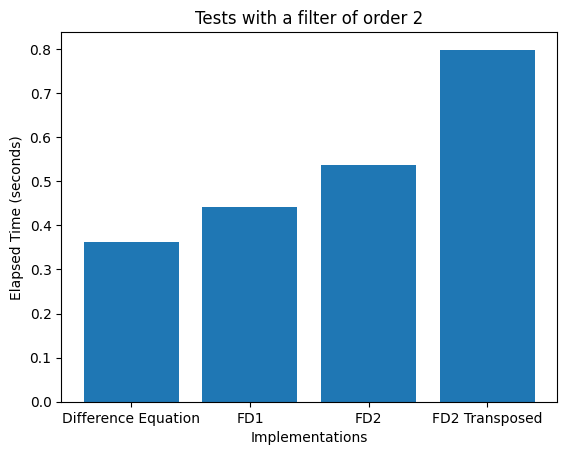

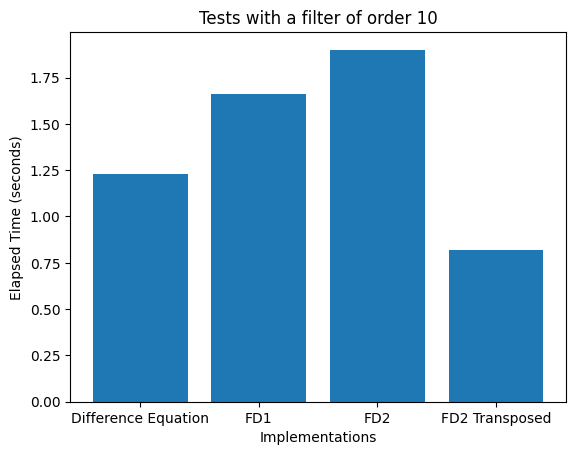

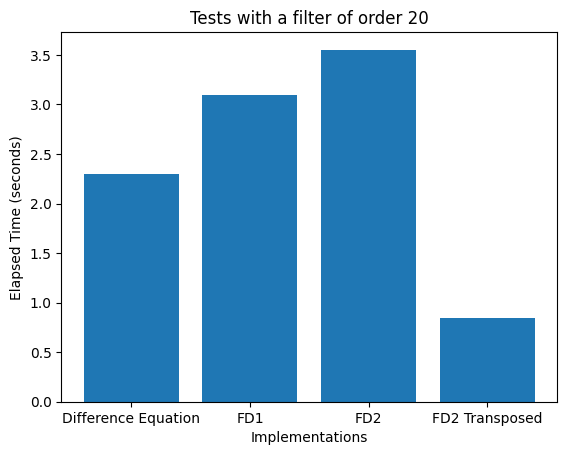

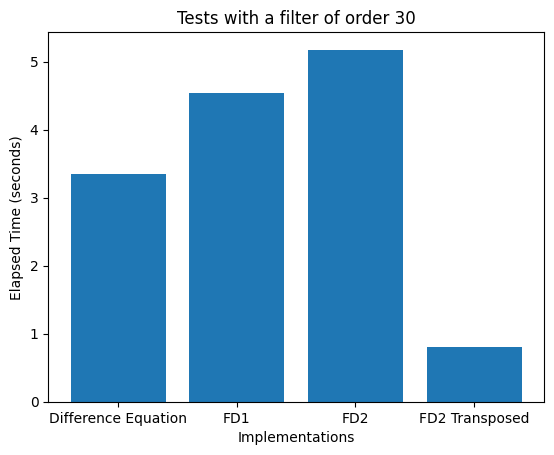

In [11]:
tests = ['Difference Equation', 'FD1', 'FD2', 'FD2 Transposed']
values0 = etime[0][:]

plt.bar(tests,values0, width = 0.8)
plt.xlabel("Implementations")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Tests with a filter of order {}".format(ordem[0]))
plt.show()

tests = ['Difference Equation', 'FD1', 'FD2', 'FD2 Transposed']
values1 = etime[1][:]

plt.bar(tests,values1, width = 0.8)
plt.xlabel("Implementations")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Tests with a filter of order {}".format(ordem[1]))
plt.show()

tests = ['Difference Equation', 'FD1', 'FD2', 'FD2 Transposed']
values2 = etime[2][:]

plt.bar(tests,values2, width = 0.8)
plt.xlabel("Implementations")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Tests with a filter of order {}".format(ordem[2]))
plt.show()

tests = ['Difference Equation', 'FD1', 'FD2', 'FD2 Transposed']
values3 = etime[3][:]

plt.bar(tests,values3, width = 0.8)
plt.xlabel("Implementations")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Tests with a filter of order {}".format(ordem[3]))
plt.show()